In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')
import catboost
import optuna

In [2]:
events_data = pd.read_csv('event_data_train.csv')

In [3]:
submissions_data = pd.read_csv('submissions_data_train.csv')

In [4]:
submissions_data.head(3)

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853


In [5]:
# adding new columns
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date

submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

# calculating for each user count correct submimit
users_scores = submissions_data.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()

users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={
    'timestamp': 'last_timestamp'
})

now = 1526772811
drop_out_treshold = 30 * 24 * 60 * 60 # пороговое значение
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_treshold

users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data = users_data.fillna(0)

users_events_data = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()
users_data = users_data.merge(users_events_data, how='outer')

users_days = events_data.groupby('user_id').day.nunique()
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_data = users_data.merge(users_days, how='outer')

users_data['passed_course'] = users_data.passed > 175


In [6]:
users_data.sample(2)

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
9240,12835,1512051555,True,26.0,58.0,84,74,50,180,4,False
8830,12273,1526243953,False,0.0,0.0,1,0,1,1,1,False


In [7]:
users_data[users_data.passed_course].day.median()

21.0

<AxesSubplot: >

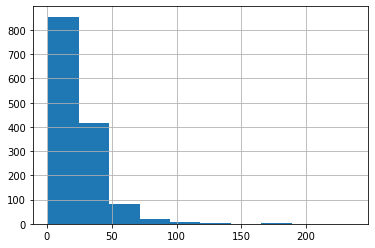

In [8]:
users_data[users_data.passed_course].day.hist()

In [9]:
events_data.sample(3)

,step_id,timestamp,action,user_id,date,day
553557,33478,1436803324,discovered,24273,2015-07-13 16:02:04,2015-07-13
1650938,33930,1480504959,viewed,9659,2016-11-30 11:22:39,2016-11-30
2422980,33915,1503210587,viewed,12213,2017-08-20 06:29:47,2017-08-20


In [10]:
temp = events_data.groupby(by=['user_id'], as_index=False).agg({'day': 'min'})

In [11]:
temp.sample(2)

,user_id,day
10396,14438,2016-08-28
17381,24207,2016-06-25


In [12]:
users_data = users_data.merge(temp, how='inner', on='user_id').rename({'day_y':'start'},axis=1)

In [13]:
users_data.sample(2)

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day_x,passed_course,start
12956,18009,1526745933,False,0.0,0.0,1,1,0,1,1,False,2018-05-19
17354,24170,1460550607,True,77.0,29.0,193,193,81,390,13,True,2015-06-30


In [14]:
users_data['count_date'] = pd.to_datetime(users_data.last_timestamp, unit='s').dt.date - users_data.start

In [15]:
users_data.sample(2)

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day_x,passed_course,start,count_date
737,995,1487962485,True,0.0,1.0,5,2,2,18,3,False,2017-02-21,3 days
10270,14263,1441382289,True,0.0,0.0,1,0,0,1,1,False,2015-09-04,0 days


In [16]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19234 entries, 0 to 19233
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   user_id          19234 non-null  int64          
 1   last_timestamp   19234 non-null  int64          
 2   is_gone_user     19234 non-null  bool           
 3   correct          19234 non-null  float64        
 4   wrong            19234 non-null  float64        
 5   discovered       19234 non-null  int64          
 6   passed           19234 non-null  int64          
 7   started_attempt  19234 non-null  int64          
 8   viewed           19234 non-null  int64          
 9   day_x            19234 non-null  int64          
 10  passed_course    19234 non-null  bool           
 11  start            19234 non-null  object         
 12  count_date       19234 non-null  timedelta64[ns]
dtypes: bool(2), float64(2), int64(7), object(1), timedelta64[ns](1)
memory usage

In [17]:
X = users_data[['count_date']]/pd.Timedelta(days=1)
y = users_data[['passed_course']]

In [18]:
X = X.values

In [19]:
y = LabelEncoder().fit_transform(y.values)

In [20]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,shuffle=True)

In [21]:
model = tree.DecisionTreeClassifier(criterion='entropy')

In [22]:
model.__dict__

{'criterion': 'entropy',
 'splitter': 'best',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': None,
 'max_leaf_nodes': None,
 'random_state': None,
 'min_impurity_decrease': 0.0,
 'class_weight': None,
 'ccp_alpha': 0.0}

In [23]:
param = {'max_depth':range(10),'min_samples_split':range(2,11),'min_samples_leaf':range(1,11)}

In [24]:
cv = model_selection.GridSearchCV(model, param, n_jobs=-1).fit(X_train, y_train)

In [25]:
cv.score(X_test, y_test)

0.9270490382949229

[Text(0.5, 0.75, 'X[0] <= 14.5\nentropy = 0.373\nsamples = 13463\nvalue = [12494, 969]'),
 Text(0.25, 0.25, 'entropy = 0.042\nsamples = 8902\nvalue = [8861, 41]'),
 Text(0.75, 0.25, 'entropy = 0.729\nsamples = 4561\nvalue = [3633, 928]')]

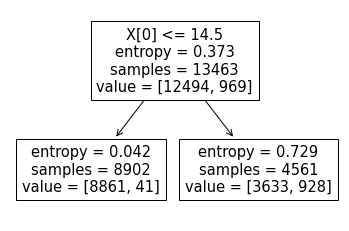

In [26]:
tree.plot_tree(cv.best_estimator_)

In [27]:
err = submissions_data.query('submission_status=="wrong"')

In [28]:
err.head(3)

,step_id,timestamp,submission_status,user_id,date,day
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
15,32031,1434363465,wrong,15853,2015-06-15 10:17:45,2015-06-15


In [29]:
err.groupby(by='step_id', as_index=False).agg('count').sort_values(by='submission_status',ascending=False)

,step_id,timestamp,submission_status,user_id,date,day
4,31978,16084,16084,16084,16084,16084
11,32031,13373,13373,13373,13373,13373
19,32202,13002,13002,13002,13002,13002
44,33481,10300,10300,10300,10300,10300
12,32075,10003,10003,10003,10003,10003
...,...,...,...,...,...,...
45,33482,707,707,707,707,707
59,33681,703,703,703,703,703
36,33362,673,673,673,673,673
16,32175,342,342,342,342,342


In [30]:
cat = catboost.CatBoostClassifier(custom_loss=['Accuracy','AUC']).fit(X_train,y_train,eval_set=(X_test, y_test),verbose=False,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [9]:
from sklearn import ensemble
import numpy as np

In [10]:
url = "https://raw.githubusercontent.com/sanyathisside/Predicting-Heart-Disease-using-Machine-Learning/master/heart-disease.csv"

df = pd.read_csv(url)


In [11]:
df.sample(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
225,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
152,64,1,3,170,227,0,0,155,0,0.6,1,0,3,1


In [12]:
X_train = df.drop(['target'],axis=1)
y_train = df[['target']]

In [13]:
np.random.seed(0)

rf = ensemble.RandomForestClassifier(10, max_depth=5)
rf.fit(X_train,y_train)


RandomForestClassifier(max_depth=5, n_estimators=10)

In [14]:
rf.feature_importances_

array([0.04344095, 0.0399895 , 0.1399832 , 0.0535693 , 0.05688662,
       0.00849278, 0.01858343, 0.12954976, 0.04807909, 0.11664461,
       0.06920762, 0.07704782, 0.19852531])

In [15]:
X_train.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [16]:
df = pd.DataFrame(rf.feature_importances_,index=X_train.columns,columns=['imp']).sort_values(by='imp')

<AxesSubplot: >

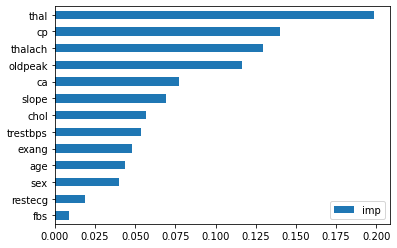

In [17]:
df.plot(kind='barh')

In [18]:
!pip install shap

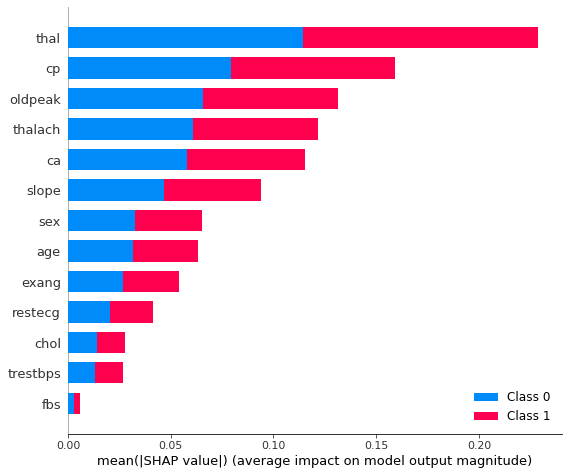

In [26]:
import shap

shap_test = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_test, X_train, auto_size_plot=True)
